In [1]:
#imports
from ipywidgets import interact
import unidecode
import pandas as pd
import random
import json
from collections import Counter
from itertools import chain
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import re
#https://pypi.org/project/tqdm/ information on tqdm
from tqdm import tqdm
tqdm.pandas()

#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
init_notebook_mode(connected=True)
import plotly.offline as offline
import plotly.graph_objs as go
import plotly.express as px

# Data Modeling
from sklearn.ensemble import VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import FastText, Word2Vec
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_validate, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn import model_selection 
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')

In [2]:
train=pd.read_json('train.json')
test=pd.read_json('test.json')

In [3]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9944 entries, 0 to 9943
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           9944 non-null   int64 
 1   ingredients  9944 non-null   object
dtypes: int64(1), object(1)
memory usage: 155.5+ KB
None


In [4]:
train.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [5]:
train.cuisine.unique()

array(['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
       'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
       'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
       'irish', 'korean', 'moroccan', 'russian'], dtype=object)

<AxesSubplot:>

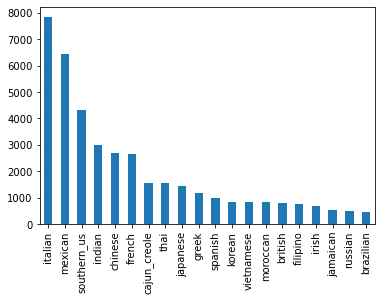

In [6]:
train['cuisine'].value_counts().plot.bar()

In [7]:
raw_ing=[i for ing in train['ingredients'] for i in ing]

In [8]:
len(raw_ing)

428275

In [9]:
len(set(raw_ing))

6714

In [10]:
train['num_ing']=train['ingredients'].str.len()

<AxesSubplot:xlabel='num_ing'>

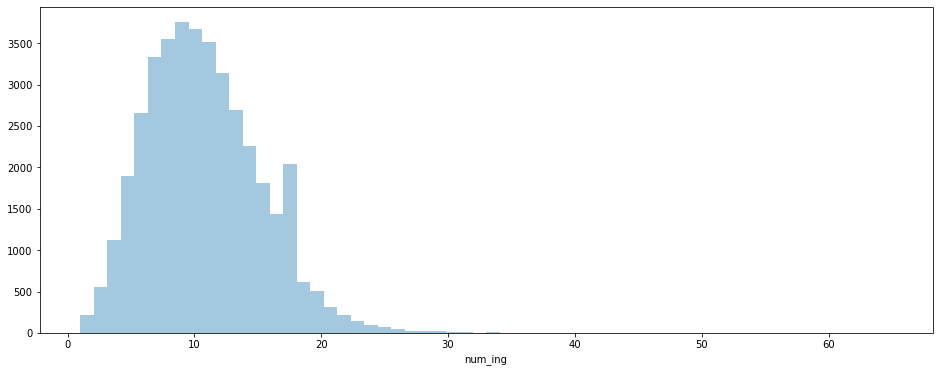

In [11]:
plt.figure(figsize=(16,6))
sns.distplot(train['num_ing'],kde =False ,bins=60)

In [12]:
top=Counter(raw_ing)
top.most_common(20)

[('salt', 18049),
 ('onions', 7972),
 ('olive oil', 7972),
 ('water', 7457),
 ('garlic', 7380),
 ('sugar', 6434),
 ('garlic cloves', 6237),
 ('butter', 4848),
 ('ground black pepper', 4785),
 ('all-purpose flour', 4632),
 ('pepper', 4438),
 ('vegetable oil', 4385),
 ('eggs', 3388),
 ('soy sauce', 3296),
 ('kosher salt', 3113),
 ('green onions', 3078),
 ('tomatoes', 3058),
 ('large eggs', 2948),
 ('carrots', 2814),
 ('unsalted butter', 2782)]

In [13]:
#top unique ingredients in specific cuisine 
def cuisine_wise(cuisine,n):
    """
    Input: 
        cuisine-cuisine category
        n-number of ingredients to be displayed
        raw_ingredients-the list of ingredients for the specific cuisine category
    Ouput:
        dataframe of top n ingredients and their frequency for the specific cuisine
    """
    mycounter=Counter()
    for ing in train[train.cuisine==cuisine]['ingredients']:
        for i in ing:
            mycounter[i]+=1
    tmp=[]
    for ing in train[train.cuisine!=cuisine]['ingredients']:
        for i in ing:
            tmp.append(i)
    others=list(set(tmp))

    for i in list(mycounter):
        if i in others:
            del mycounter[i]
    
    cuisinewise_df=pd.DataFrame(mycounter.most_common(n),columns=['ingredients','count'])
    return cuisinewise_df

In [14]:
cuisinespec= cuisine_wise('mexican', 10)
print("The top 10 unique ingredients in Mexican cuisine are:")
cuisinespec

The top 10 unique ingredients in Mexican cuisine are:


,ingredients,count
0,refried beans,250
1,taco seasoning mix,181
2,red enchilada sauce,65
3,taco sauce,63
4,poblano chilies,33
5,mexican chocolate,32
6,baked tortilla chips,31
7,green enchilada sauce,31
8,Mexican beer,30
9,chipotle,25


Pre-Processing Data

In [15]:
train.head()

,id,cuisine,ingredients,num_ing
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",9
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",11
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12
3,22213,indian,"[water, vegetable oil, wheat, salt]",4
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",20


In [16]:
#removing outliers - entries with less than 1 ingredient and greater than 60 ingredients
mask1=train.num_ing>1
mask2=train.num_ing<60
train=train[(mask1 & mask2)]

In [17]:
train.shape

(39751, 4)

In [18]:
#word preprocessing : lower casing,removing special characters,hyphens,punctuations,numbers,units,accents,lemmatization
lemmatizer=WordNetLemmatizer()
def text_pre(ingredients):
    ingredients_text = ' '.join(ingredients)
    ingredients_text = ingredients_text.lower() #Lower - Casing
    ingredients_text = ingredients_text.replace('-', ' ') # Removing Hyphen
    words = []
    for word in ingredients_text.split():
        word = re.sub("[0-9]"," ",word) #removing numbers,punctuations and special characters
        word = re.sub((r'\b(oz|ounc|ounce|pound|lb|inch|inches|kg|to)\b'), ' ', word) # Removing Units
        if len(word) <= 2: continue # Removing words with less than two characters
        word = unidecode.unidecode(word) #Removing accents
        word = lemmatizer.lemmatize(word) #Lemmatize
        if len(word) > 0: words.append(word)
    return ' '.join(words)

In [19]:
train['x'] = train['ingredients'].progress_apply(text_pre)
test['x'] = test['ingredients'].progress_apply(text_pre)
train.head()

100%|██████████| 9944/9944 [00:00<00:00, 17037.67it/s]


,id,cuisine,ingredients,num_ing,x
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",9,romaine lettuce black olive grape tomato garli...
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",11,plain flour ground pepper salt tomato ground b...
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12,egg pepper salt mayonaise cooking oil green ch...
3,22213,indian,"[water, vegetable oil, wheat, salt]",4,water vegetable oil wheat salt
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",20,black pepper shallot cornflour cayenne pepper ...


In [20]:
train['x'][0]

'romaine lettuce black olive grape tomato garlic pepper purple onion seasoning garbanzo bean feta cheese crumbles'

In [21]:
def train_model(x, y, n_splits=3):
    model = LogisticRegression(C=10, solver='sag', multi_class='multinomial', max_iter=300, n_jobs=-1)
    i = 0
    accuracies = []
    kfold = KFold(n_splits)
    for train_index, test_index in kfold.split(x):
        classifier = LogisticRegression(C=10, solver='sag', multi_class='multinomial', max_iter=300, n_jobs=-1)
        classifier.fit(x[train_index], y[train_index])
        predictions = classifier.predict(x[test_index])
        accuracies.append(accuracy_score(predictions, y[test_index]))
        i += 1
    average_accuracy = sum(accuracies) / len(accuracies)
    return average_accuracy

In [22]:
def run_experiment(preprocessor):
    train = json.load(open('./train.json'))

    target = [doc['cuisine'] for doc in train]
    lb = LabelEncoder()
    y = lb.fit_transform(target)

    x = preprocessor.fit_transform(train)

    return train_model(x, y)

In [23]:
import time
results = []
for (name, preprocessor) in [
    ('TfidfVectorizer()', make_pipeline(
        FunctionTransformer(lambda x: [" ".join(doc['ingredients']).lower() for doc in x], validate=False),
        TfidfVectorizer(),
    )),
    ('TfidfVectorizer(binary=True)', make_pipeline(
        FunctionTransformer(lambda x: [" ".join(doc['ingredients']).lower() for doc in x], validate=False),
        TfidfVectorizer(binary=True),
    )),
    ('TfidfVectorizer(min_df=3)', make_pipeline(
        FunctionTransformer(lambda x: [" ".join(doc['ingredients']).lower() for doc in x], validate=False),
        TfidfVectorizer(min_df=3),
    )),
    ('TfidfVectorizer(min_df=5)', make_pipeline(
        FunctionTransformer(lambda x: [" ".join(doc['ingredients']).lower() for doc in x], validate=False),
        TfidfVectorizer(min_df=5),
    )),
    ('TfidfVectorizer(max_df=0.95)', make_pipeline(
        FunctionTransformer(lambda x: [" ".join(doc['ingredients']).lower() for doc in x], validate=False),
        TfidfVectorizer(max_df=0.95),
    )),
     ('TfidfVectorizer(max_df=0.9)', make_pipeline(
        FunctionTransformer(lambda x: [" ".join(doc['ingredients']).lower() for doc in x], validate=False),
        TfidfVectorizer(max_df=0.9),
    )),
    ('TfidfVectorizer(sublinear_tf=True)', make_pipeline(
        FunctionTransformer(lambda x: [" ".join(doc['ingredients']).lower() for doc in x], validate=False),
        TfidfVectorizer(sublinear_tf=True),
    )),
    ('TfidfVectorizer(strip_accents=unicode)', make_pipeline(
        FunctionTransformer(lambda x: [" ".join(doc['ingredients']).lower() for doc in x], validate=False),
        TfidfVectorizer(strip_accents='unicode'),
    )),
]:
    start = time.time()
    accuracy = run_experiment(preprocessor)
    execution_time = time.time() - start
    results.append({
        'name': name,
        'accuracy': accuracy,
        'execution time': f'{round(execution_time, 2)}s'
    })
pd.DataFrame(results, columns=['name', 'accuracy', 'execution time']).sort_values(by='accuracy', ascending=False)

,name,accuracy,execution time
6,TfidfVectorizer(sublinear_tf=True),0.782572,4.11s
0,TfidfVectorizer(),0.782471,4.16s
4,TfidfVectorizer(max_df=0.95),0.782471,4.24s
5,TfidfVectorizer(max_df=0.9),0.782471,4.24s
7,TfidfVectorizer(strip_accents=unicode),0.782421,4.54s
2,TfidfVectorizer(min_df=3),0.782370,4.32s
1,TfidfVectorizer(binary=True),0.781943,4.45s
3,TfidfVectorizer(min_df=5),0.781038,4.26s


In [24]:
vectorizer = TfidfVectorizer(sublinear_tf=True)
X_train = vectorizer.fit_transform(train['x'].values)
X_train.sort_indices()
X_test = vectorizer.transform(test['x'].values)
label_encoder = LabelEncoder()
Y_train = label_encoder.fit_transform(train['cuisine'].values)

In [25]:
classifier = SVC(C=100, # penalty parameter
	 			 kernel='rbf', # kernel type, rbf working fine here
	 			 degree=3, # default value
	 			 gamma=1, # kernel coefficient
	 			 coef0=1, # change to 1 from default value of 0.0
	 			 shrinking=True, # using shrinking heuristics
	 			 tol=0.001, # stopping criterion tolerance 
	      		 probability=True, # no need to enable probability estimates
	      		 cache_size=200, # 200 MB cache size
	      		 class_weight=None, # all classes are treated equally 
	      		 verbose=False, # print the logs 
	      		 max_iter=-1, # no limit, let it run
          		 decision_function_shape='ovr', # will use one vs rest explicitly 
          		 random_state=None)

In [ ]:
classifier.fit(X_train, Y_train)

SVC(C=100, coef0=1, gamma=1)

In [ ]:
Y_test = classifier.predict(X_test)
Y_pred = label_encoder.inverse_transform(Y_test)

In [95]:
test_id = test['id']
sub = pd.DataFrame({'id': test_id, 'cuisine': Y_pred}, columns=['id', 'cuisine'])
sub.to_csv('submission.csv', index=False)

In [26]:
mnb = MultinomialNB()
nn = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)

In [27]:
voting_clf = VotingClassifier(estimators=[('svc', classifier), ('mnb', mnb), ('nn', nn)], voting='soft')
voting_clf.fit(X_train, Y_train)

VotingClassifier(estimators=[('svc',
                              SVC(C=100, coef0=1, gamma=1, probability=True)),
                             ('mnb', MultinomialNB()),
                             ('nn',
                              MLPClassifier(max_iter=1000, random_state=42))],
                 voting='soft')

In [28]:
Y_test_voting = voting_clf.predict(X_test)
Y_pred_voting = label_encoder.inverse_transform(Y_test_voting)

In [30]:
test_id = test['id']
sub = pd.DataFrame({'id': test_id, 'cuisine': Y_pred_voting}, columns=['id', 'cuisine'])
sub.to_csv('submission1.csv', index=False)